In [1]:
import sys
import os

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.animation as animation

sys.path.insert(0, os.path.abspath("../cli"))
from simulation.sonar import Sonar
from simulation.utils import (
    FlatBottom,
    CircleBottom,
    EllipsisBottom,
    run_beam,
    positions_line,
    positions_half_circle,
)
from simulation.plotting import plot_velocity, plot_attenuation
from simulation.sources import GaborSource

from examples.seismic import WaveletSource, Receiver
from devito import configuration

configuration["log-level"] = "ERROR"
plt.rcParams["figure.figsize"] = (5, 5)
sys.stderr = open(os.devnull, "w")

### Functions and Source

In [2]:
def plot_snapshot_and_signal(
    snap: npt.NDArray,
    recording: npt.NDArray,
    model,
    outfile,
    source_coords = None,
    receiver_coords = None,
):
    fig, ax = plt.subplots(
        2,
        1,
        figsize=(10, 15),
        gridspec_kw={"width_ratios": [1], "height_ratios": [2, 1]},
    )
    snap_step = int(recording.shape[0] / snap.shape[0])
    domain_size = np.array(model.domain_size)
    extent = [
        model.origin[0],
        model.origin[0] + domain_size[0],
        model.origin[1] + domain_size[1],
        model.origin[1],
    ]
    data = model.vp.data
    ax[0].imshow(
        np.transpose(data),
        cmap="viridis",
        vmin=np.min(data),
        vmax=np.max(data),
        extent=extent,
    )

    if receiver_coords is not None:
        ax[0].scatter(
            receiver_coords[:, 0], receiver_coords[:, 1], s=25, c="green", marker="o"
        )
    if source_coords is not None:
        ax[0].scatter(source_coords[:, 0], source_coords[:, 1], s=25, c="red", marker="o")

    ampl_limit = max(abs(np.min(snap)), abs(np.max(snap)))
    matrice = ax[0].imshow(
        snap[0, :, :].T,
        vmin=-ampl_limit,
        vmax=ampl_limit,
        cmap="seismic",
        alpha=0.6,
        extent=extent,
    )

    (aline,) = ax[1].plot(recording[:1])
    ax[1].set_ylim(1.1 * np.min(recording), 1.1 * np.max(recording))
    ax[1].set_xlim(0, len(recording))

    def update(i):
        matrice.set_array(snap[i, :, :].T)
        aline.set_data(np.arange(i * snap_step), recording[: i * snap_step])
        return (matrice, aline)

    ani = animation.FuncAnimation(
        fig, update, frames=snap.shape[0], interval=300, blit=True
    )
    ani.save(outfile)
    plt.close(ani._fig)


In [3]:
def get_ideal_signal(domain_size, f0, v_env, sd, ns, posy, angle,dt,spatial_dist,space_order, plot = False):
    max_distance = domain_size[1]
    t_end = max_distance / v_env
    s = Sonar(domain_size, f0, v_env, CircleBottom(domain_size[0] / 2, domain_size[1] / 2, domain_size[1] / 2), dt = dt, tn=t_end, spatial_dist=spatial_dist, space_order=space_order)
    src_coord = np.array([(domain_size[0] - sd * ns) / 2, domain_size[1] / 2]) + positions_line(
        stop_x=ns * sd, posy=sd, n=ns
    )
    src = GaborSource(
        name="src",
        grid=s.model.grid,
        npoint=ns,
        f0=f0,
        time_range=s.time_range,
        coordinates_data=src_coord,
    )
    distance = domain_size[1] / 2 * posy
    rec_x = domain_size[0] / 2 - np.cos(np.deg2rad(angle)) * distance
    rec_y = domain_size[1] / 2 + np.sin(np.deg2rad(angle)) * distance
    rec = Receiver(
        name="rec",
        grid=s.model.grid,
        time_range=s.time_range,
        npoint=1,
        coordinates=np.array([[rec_x, rec_y]]),
    )
    s.set_source(src, rec)
    s.finalize()
    recording = run_beam(s.src, s.rec, s.op, s.u, sd, s.time_range, s.model.critical_dt, angle, v_env)
    if plot:
        plot_velocity(s.model, source=src.coordinates.data, receiver=rec.coordinates.data)
        plt.plot(recording)
    return recording[:, 0]

### Beamforming

In [12]:
v_env = 1.5
domain_size = (10, 10)
f0 = 50
angles = [45, 60, 75, 90, 105, 120, 135]
sonars = {a: Sonar(domain_size, f0, v_env, FlatBottom()) for a in angles}

In [13]:
ns = 128
source_distance = 0.002
cy = (ns - 1) / 2 * source_distance + source_distance

src_coord = np.array(
    [(domain_size[0] - source_distance * ns) / 2, cy]
) + positions_line(stop_x=ns * source_distance, posy=source_distance, n=ns)

src = GaborSource(
    name="src",
    grid=sonars[45].model.grid,
    npoint=ns,
    f0=f0,
    time_range=sonars[45].time_range,
    coordinates=src_coord,
)

rec = Receiver(
    name="rec",
    grid=sonars[45].model.grid,
    time_range=sonars[45].time_range,
    npoint=180,
    coordinates=positions_half_circle(domain_size[0] / 2, domain_size[1] / 2, cy),
)

for _, v in sonars.items():
    v.set_source(src, rec)
    v.finalize()

In [14]:
print(f'The computational grid has {sonars[45].model.grid.shape} grid points and physical size of {sonars[45].model.grid.extent} m')
print(f'The time step is {sonars[45].model.critical_dt}')
print(f'fs: {1 / sonars[45].model.critical_dt}')
print(f'Spacing: {sonars[45].model.spacing_map}')
print(f'Time range: {sonars[45].time_range.num}')

The computational grid has (2508, 2508) grid points and physical size of (12.535, 12.535) m
The time step is 0.0005
fs: 2000.0
Spacing: {h_x: 0.005, h_y: 0.005}
Time range: 39816


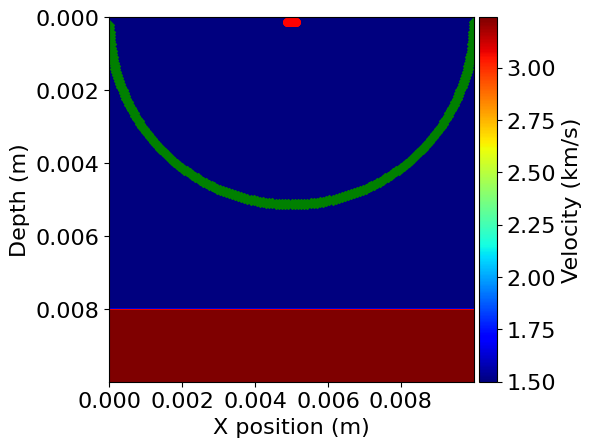

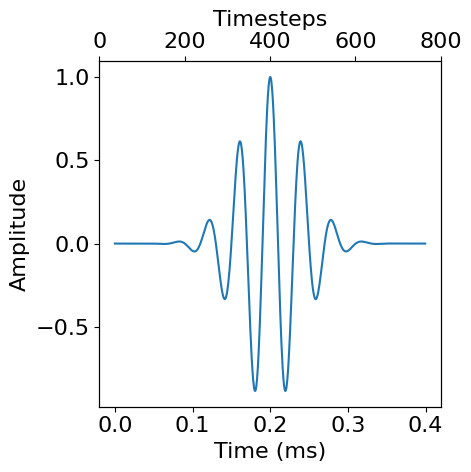

In [15]:
plot_velocity(sonars[45].model, source=sonars[45].src.coordinates.data, receiver=sonars[45].rec.coordinates.data)

plt.figure()
plt.plot(sonars[45].src.time_values[:800], sonars[45].src.signal_packet)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
ax2 = plt.gca().twiny()
ax2.set_xlim(0, 800)
ax2.set_xlabel('Timesteps')
plt.tight_layout()
plt.show()


In [16]:
recordings = {}
for a, s in sonars.items():
    recordings[a] = run_beam(
        s.src,
        s.rec,
        s.op,
        s.u,
        s.source_distance,
        s.time_range,
        s.model.critical_dt,
        a,
        v_env,
    )

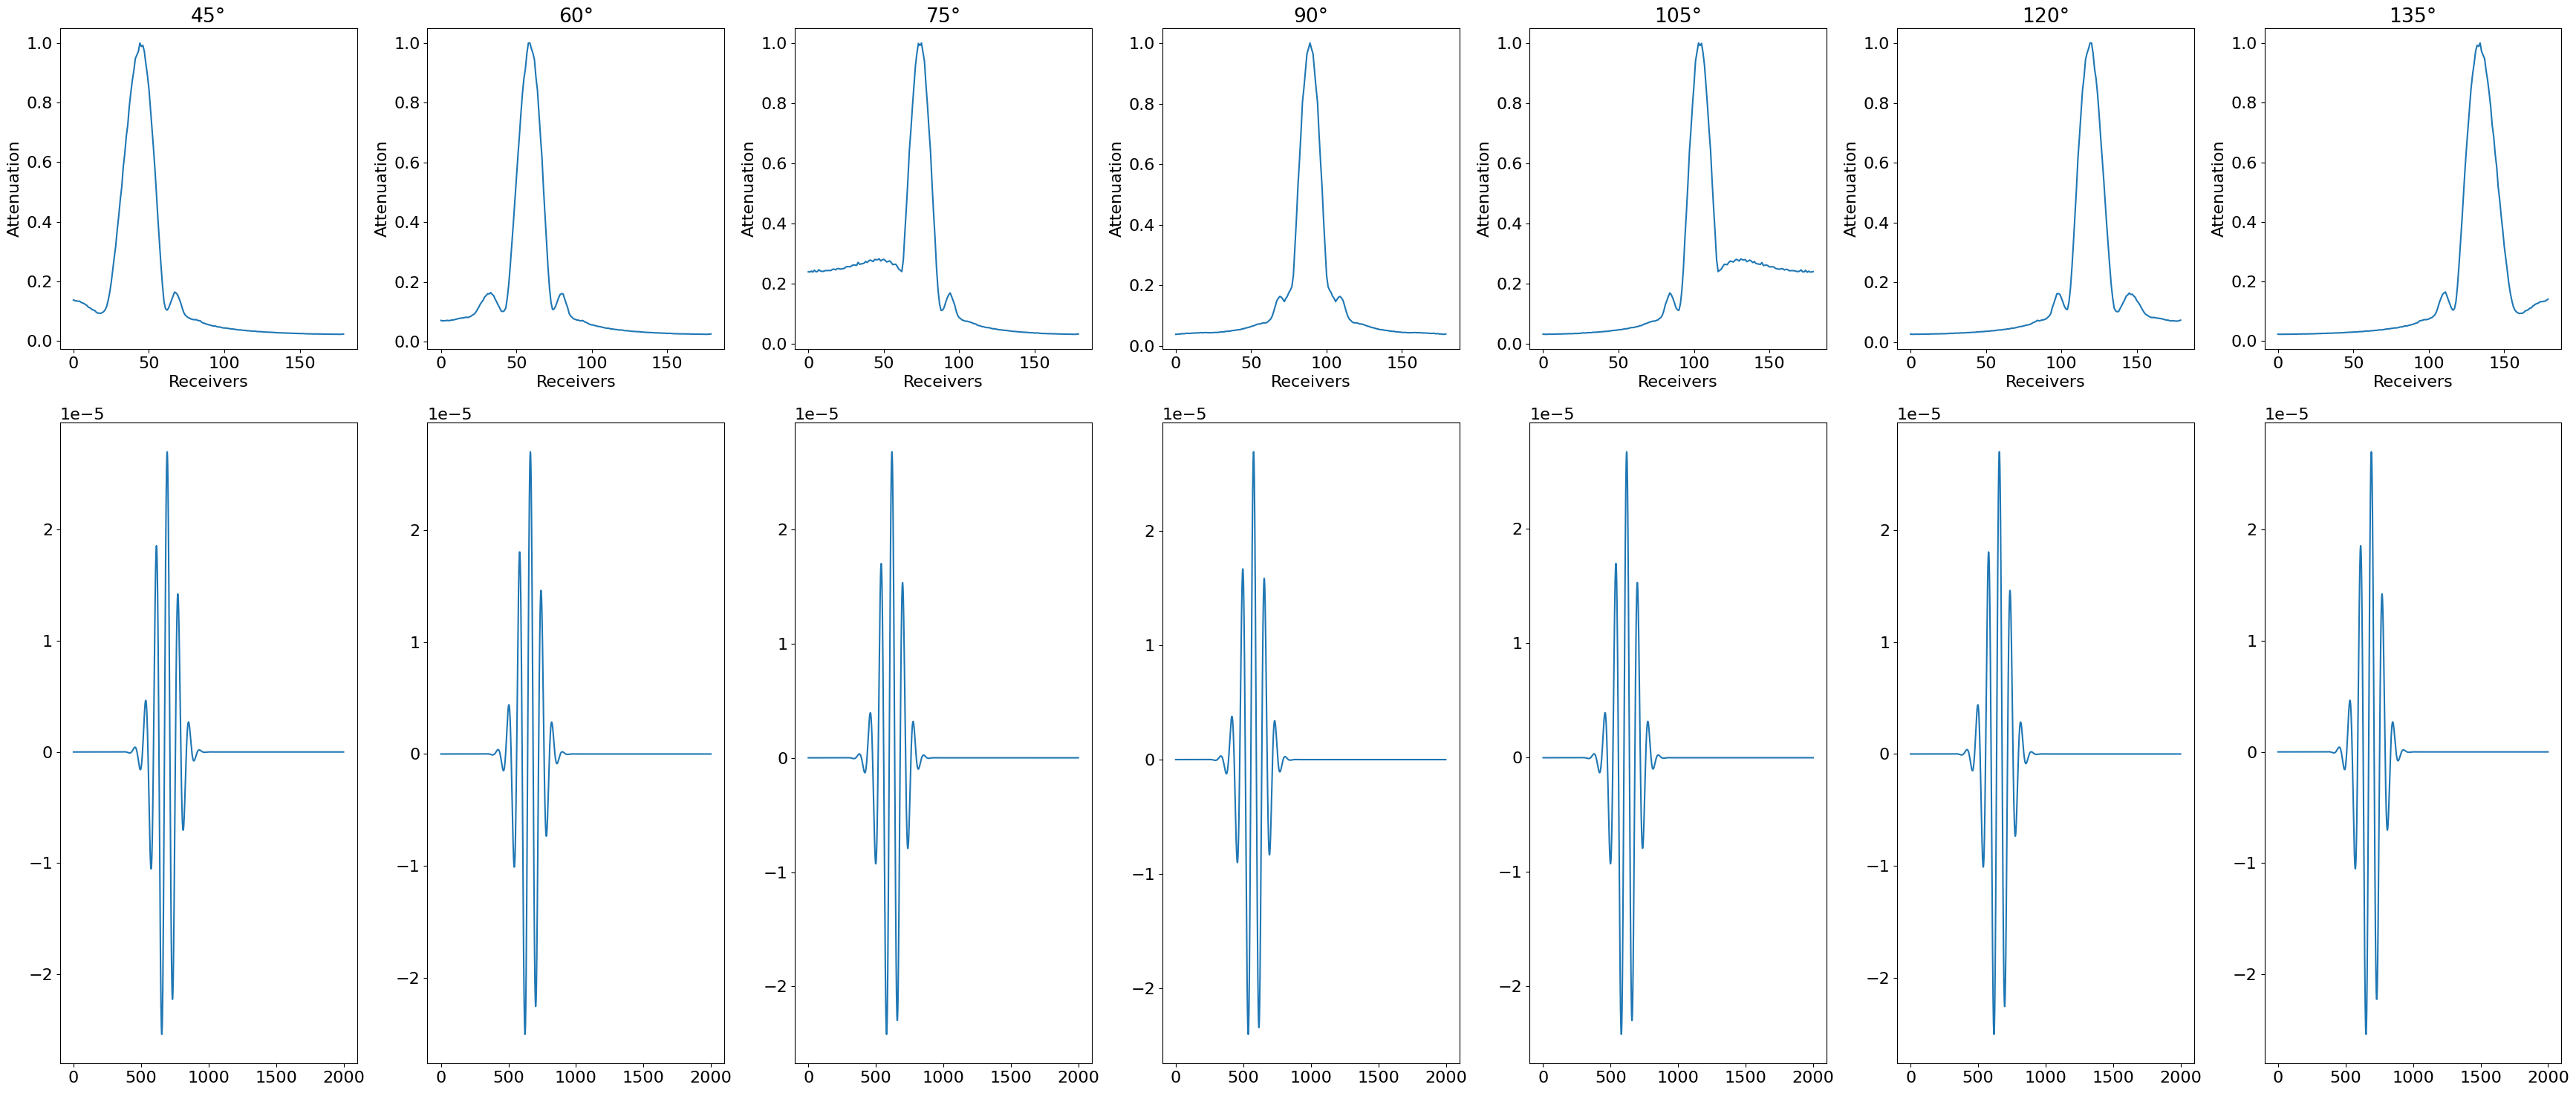

In [17]:
fig, ax = plt.subplots(2, 7, figsize=(35, 15), gridspec_kw={"height_ratios": [1, 2]})
for i, (a, r) in enumerate(recordings.items()):
    recording = np.flip(r)
    ax[0, i].plot(
        np.max(np.abs(recording[:, :]), axis=0) / np.max(np.abs(recording[:, :]))
    )
    ax[0, i].set_xlabel("Receivers")
    ax[0, i].set_ylabel("Attenuation")
    ax[0, i].set_title(f"{a}°")
    ax[0, i].tick_params()
    
    ax[1, i].plot(r[6500:8500, 180 - a])
fig.tight_layout()

### Ideal signal

In [10]:
domain_size = (20, 20)
distances = [0.25, 0.5, 0.75]
ideal_signals_90 = {}
snaps = {}
for d in distances:
    ideal_signals_90[d] = get_ideal_signal(
        domain_size,
        f0,
        v_env,
        source_distance,
        ns,
        d,
        90,
        dt,
        spatial_dist,
        space_order,
        plot=False,
    )

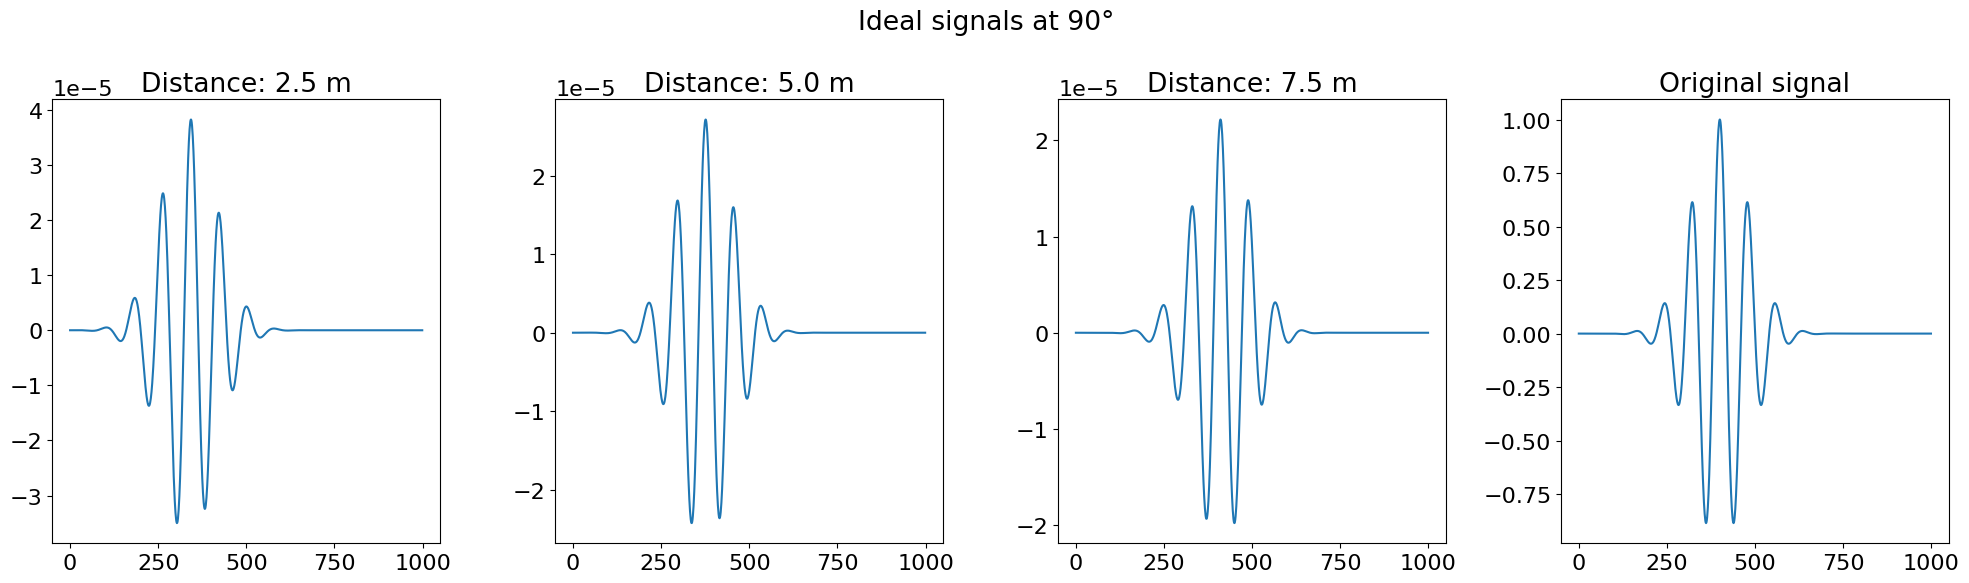

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle("Ideal signals at 90°")
ax[0].plot(ideal_signals_90[.25][3400:4400])
ax[0].set_title(f'Distance: {distances[0] * 20 / 2} m')
ax[1].plot(ideal_signals_90[.5][6700:7700])
ax[1].set_title(f'Distance: {distances[1] * 20 / 2} m')
ax[2].plot(ideal_signals_90[.75][10000:11000])
ax[2].set_title(f'Distance: {distances[2] * 20 / 2} m')
ax[3].plot(src.data[:1000,0])
ax[3].set_title(f'Original signal')
fig.tight_layout()
plt.savefig("ideal_signals_90.pdf", bbox_inches="tight", dpi=600, format="pdf")

In [12]:
domain_size = (20, 20)
distances = [0.25, 0.5, 0.75]
ideal_signals_45 = {}
for d in distances:
    ideal_signals_45[d] = get_ideal_signal(
        domain_size,
        f0,
        v_env,
        source_distance,
        ns,
        d,
        45,
        dt,
        spatial_dist,
        space_order,
        plot=False,
    )

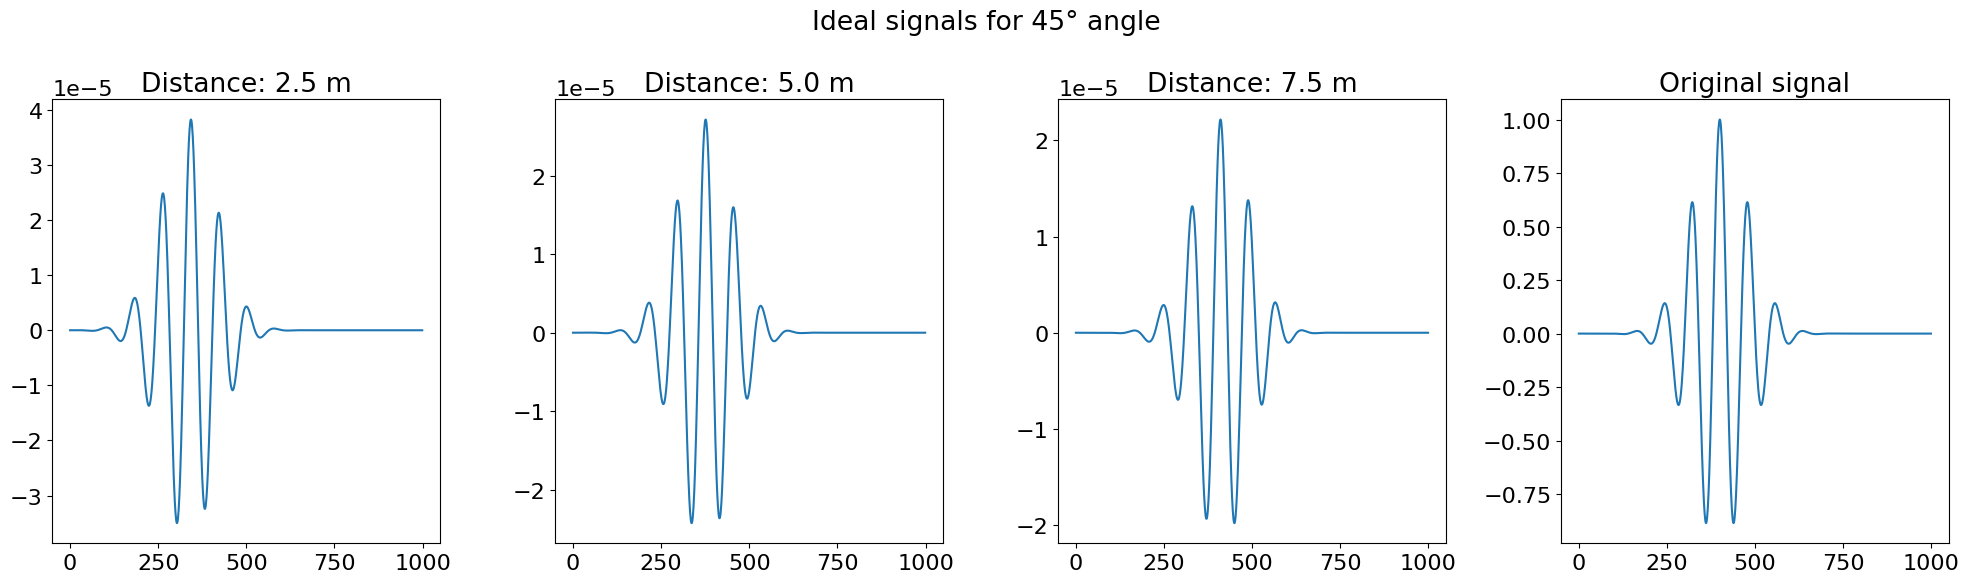

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))
fig.suptitle('Ideal signals for 45° angle')
ax[0].plot(ideal_signals_90[.25][3400:4400])
ax[0].set_title(f'Distance: {distances[0] * 20 / 2} m')
ax[1].plot(ideal_signals_90[.5][6700:7700])
ax[1].set_title(f'Distance: {distances[1] * 20 / 2} m')
ax[2].plot(ideal_signals_90[.75][10000:11000])
ax[2].set_title(f'Distance: {distances[2] * 20 / 2} m')
ax[3].plot(src.data[:1000,0])
ax[3].set_title(f'Original signal')
fig.tight_layout()
# save the figure as pdf
plt.savefig("ideal_signals_45.pdf", bbox_inches="tight", dpi=600, format="pdf")

### Detection with correlation

In [18]:
domain_size = (6, 3)
radius = 2.8
v_env = 1.5
ns = 128
source_distance = 0.002
cy = (ns - 1) / 2 * source_distance + source_distance
f0 = 50

In [19]:
sonar = Sonar(domain_size, f0, v_env, CircleBottom(domain_size[0] / 2, cy, radius))
sonar.set_source()
sonar.finalize()

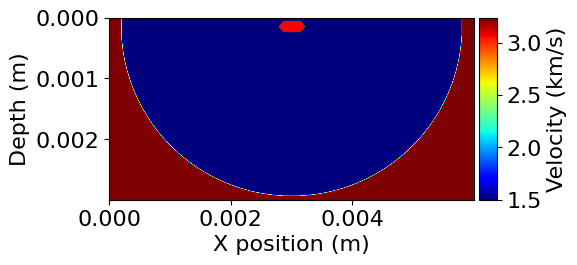

In [20]:
plot_velocity(sonar.model, source=sonar.src.coordinates.data, receiver=sonar.rec.coordinates.data)

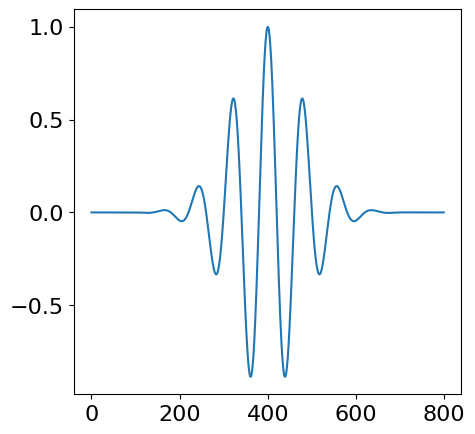

In [21]:
ideal_signal = sonar.src.signal_packet
plt.plot(ideal_signal)
plt.show()

In [22]:
recording_45 = run_beam(
        sonar.src,
        sonar.rec,
        sonar.op,
        sonar.u,
        sonar.source_distance,
        sonar.time_range,
        sonar.model.critical_dt,
        45,
        v_env,
    )

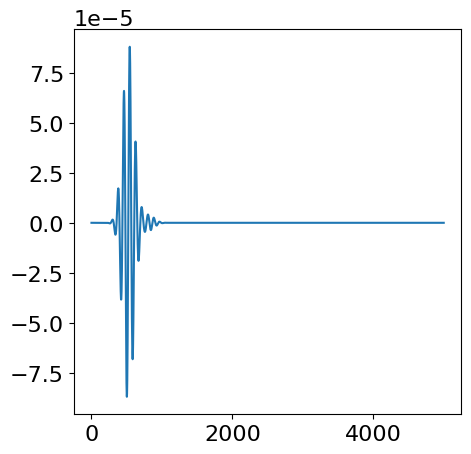

In [23]:
plt.plot(recording_45[:5000, 64])
start_time = np.argmax(recording_45[:5000, 64])

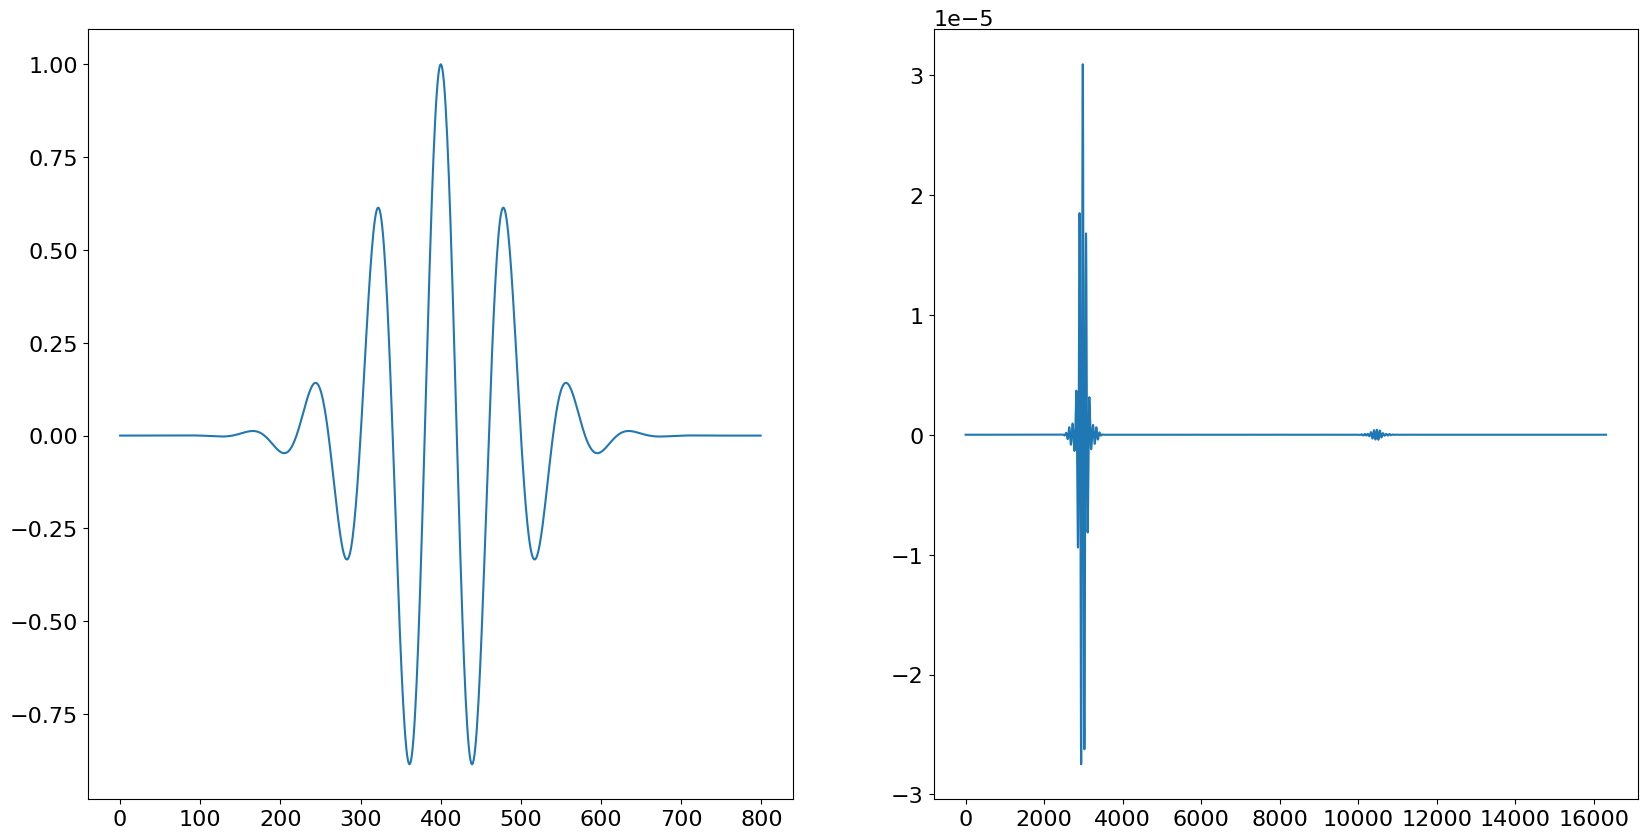

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].plot(ideal_signal)
ax[1].plot(recording_45[5000:, 64])

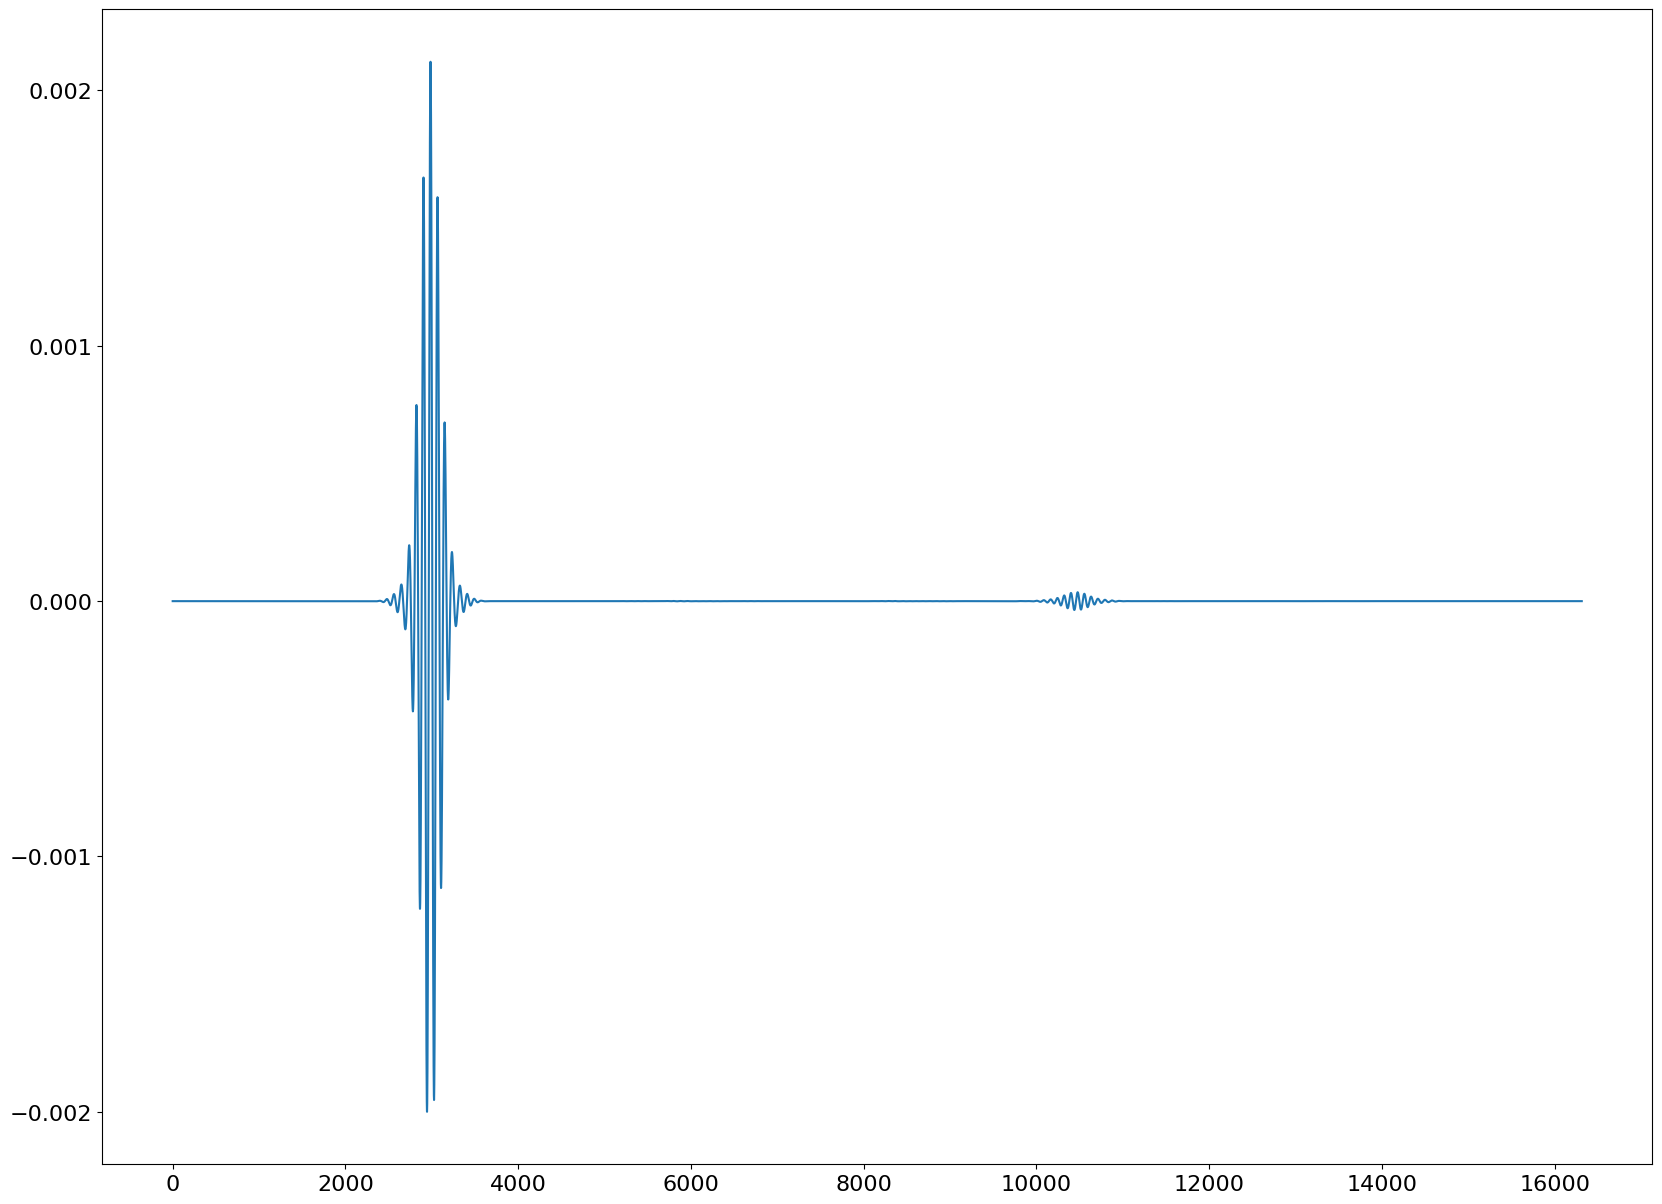

2985


In [25]:
correlate = np.correlate(recording_45[5000:, 64], ideal_signal, mode='same')
plt.figure(figsize=(20, 15))
plt.plot(correlate)
plt.show()
print(np.argmax(correlate))

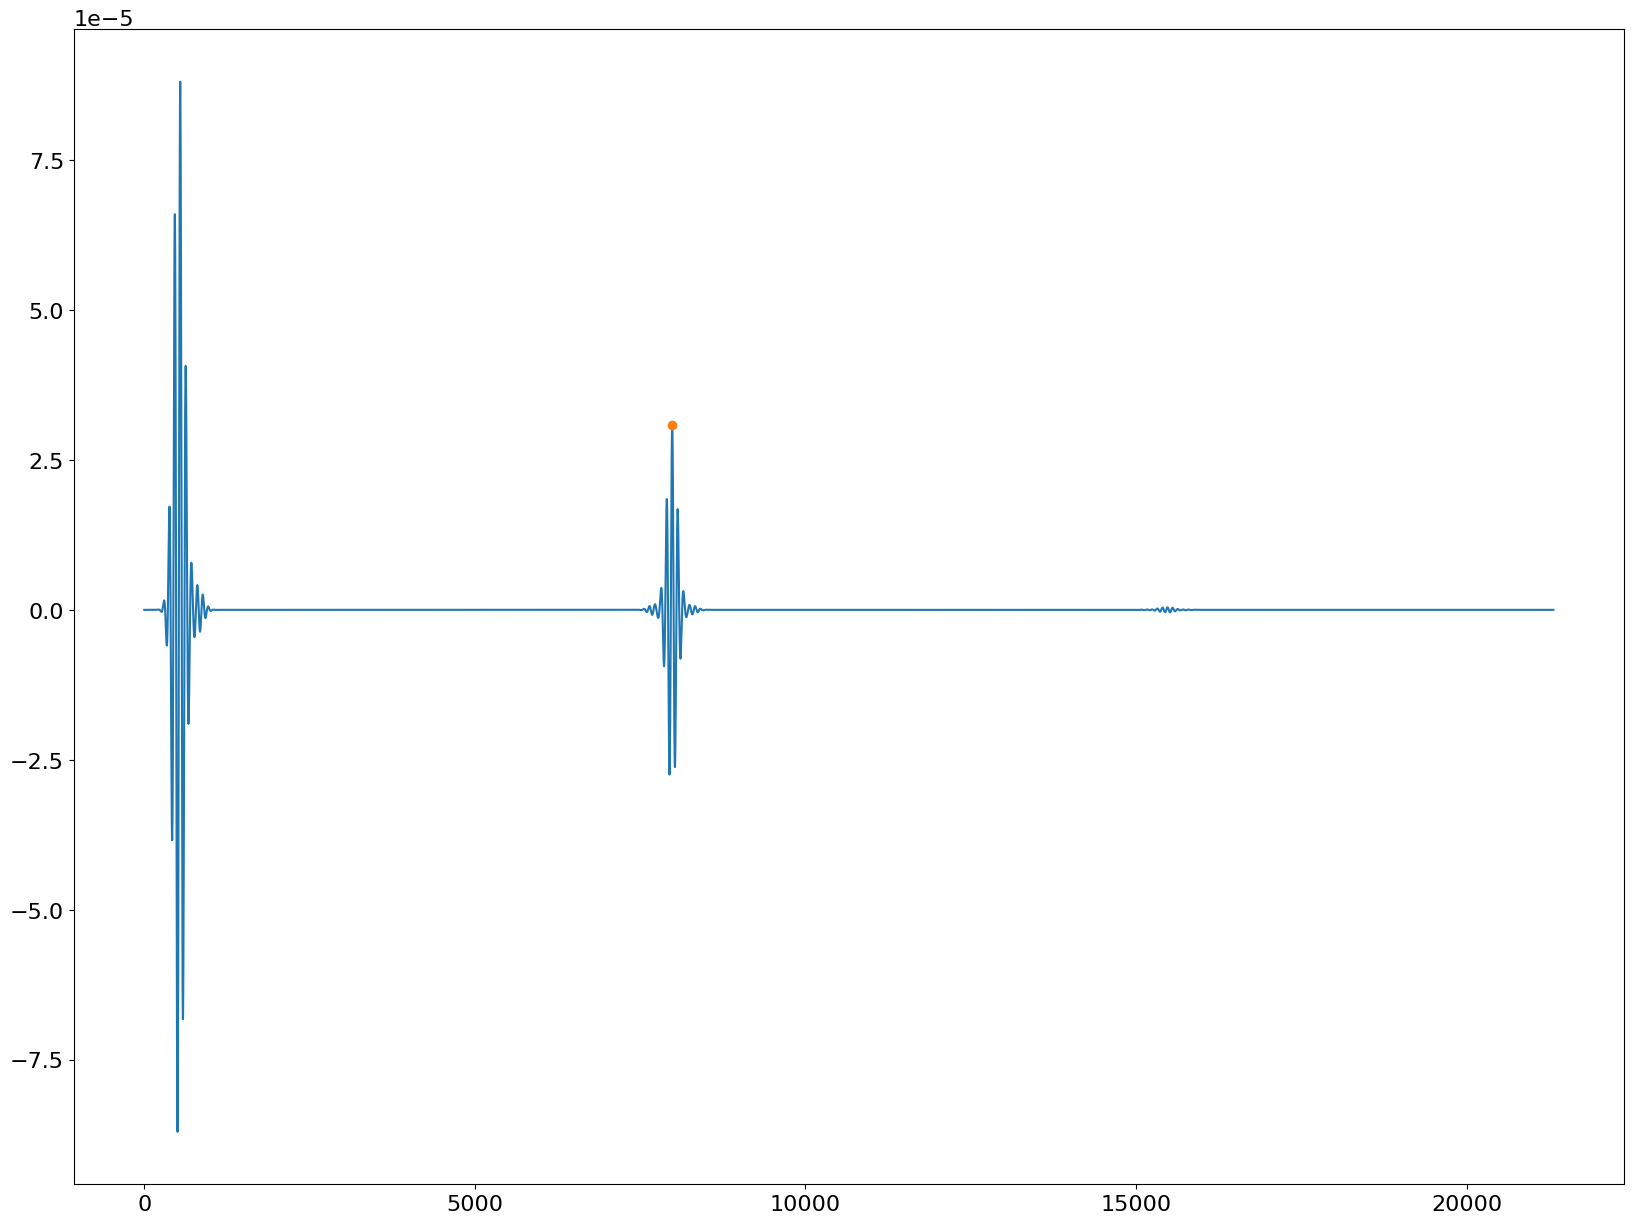

In [26]:
peak = 5000 + correlate.argmax()
## change the figure size
plt.figure(figsize=(20, 15))
plt.plot(recording_45[:, 64])
plt.plot(peak, recording_45[peak, 64], 'o')
plt.show()

In [27]:
print(f"Distance: {(peak - start_time) * sonar.model.critical_dt * v_env / 2} m")

Distance: 2.79075 m


### f0 ~ dx ~ dt

In [7]:
domain_size = (60, 30)
v_env = 1.5
ns = 128
source_distance = 0.002
f0s = [5, 10, 25, 50]
angle = 90

spatial_dist: 0.05
dt: 0.005
200.0
clang -O3 -g -fPIC -Wall -Wno-unused-result -Wno-unused-variable -ffast-math -Xopenmp-target -march=sm_70 -shared -fopenmp -fopenmp-targets=nvptx64-nvidia-cuda /tmp/devito-jitcache-uid543800090/18b96c3a1dd45c2d362ee6f3c70b1fea8ff5f36b.c -lm -o /tmp/devito-jitcache-uid543800090/18b96c3a1dd45c2d362ee6f3c70b1fea8ff5f36b.so


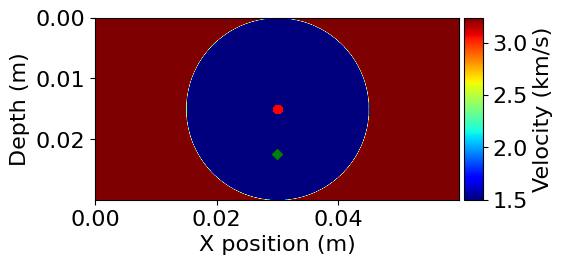

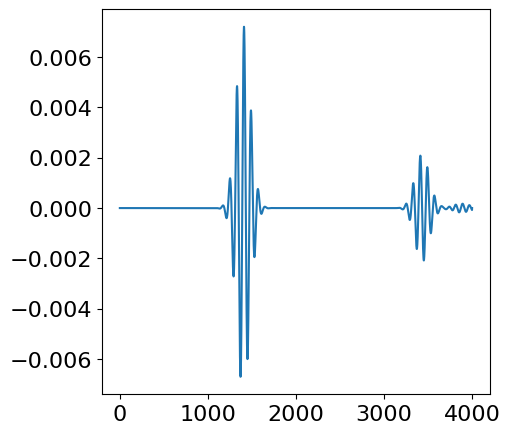

In [14]:
f0 = 50
spatial_dist = round(v_env / f0 / 3, 3) / 2
dt = spatial_dist / 10
print(f"spatial_dist: {spatial_dist}")
print(f"dt: {dt}")
print(f"{1 / dt}")
recording = get_ideal_signal(domain_size, f0, v_env, source_distance, ns, 0.5, 90, dt, spatial_dist, space_order = 4, plot=True)

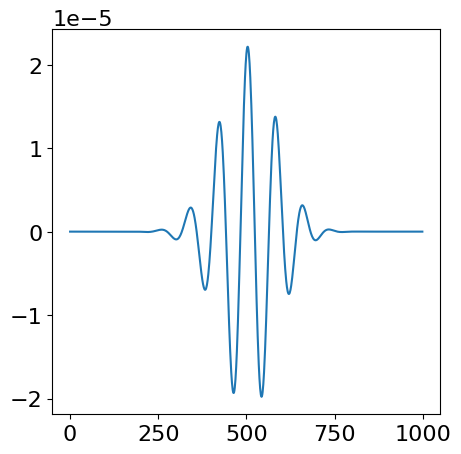

In [13]:
plt.plot(recording[9900:10900])

### Snapshot

In [28]:
domain_size = (6, 3)
radius = 2.8
v_env = 1.5
source_distance = 0.002
ns = 128
cy = (ns - 1) / 2 * source_distance + source_distance
f0 = 50

In [29]:
sonar = Sonar(domain_size, f0, v_env, CircleBottom(domain_size[0] / 2, cy, radius), source_distance=source_distance, ns=ns)
sonar.set_source()
sonar.finalize(snapshot_delay=0.1)

In [31]:
recording = run_beam(
                    sonar.src,
                    sonar.rec,
                    sonar.op,
                    sonar.u,
                    source_distance,
                    sonar.time_range,
                    sonar.model.critical_dt,
                    45,
                    v_env,
                )
plot_snapshot_and_signal(sonar.usave.data, recording[:, 64], sonar.model, f"signal_boundary.gif", sonar.src.coordinates.data, sonar.rec.coordinates.data)